Three: sz = 128, resnet 101, bs240, 1,000images CUDA OOM

       sz = 128, resnet 101, bs160, 1,000images 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import cv2
import shutil
import PIL

from fastai import *
from fastai.vision import *

import json

In [3]:
NUM_SAMPLES_PER_CLASS = 1_000
NUM_VAL = 50 * 340

## Generate data from csvs

In [4]:
mkdir data/txt

mkdir: cannot create directory ‘data/txt’: File exists


In [5]:
mkdir data/txt/train

mkdir: cannot create directory ‘data/txt/train’: File exists


In [6]:
mkdir data/txt/test

mkdir: cannot create directory ‘data/txt/test’: File exists


In [7]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.sample(NUM_SAMPLES_PER_CLASS).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized,
            'word': '_'.join(row[1].word.split())
        }
        with open(f'data/txt/train/{example["word"]}_{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)
            
def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'word': 'unknown'
        }
        with open(f'data/txt/test/{example["word"]}_{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

In [8]:
%time create_test_txts_from_df('data/test_simplified.csv')

CPU times: user 31.7 s, sys: 3.23 s, total: 34.9 s
Wall time: 35 s


In [9]:
#%time for p in Path('data/train').iterdir(): create_train_txts_from_df(p)

In [10]:
# Doing it like this so %time works properly and I can have a progress indicator.
def create_train_data():
    i = 1
    for p in Path('data/train').iterdir(): 
        %time create_train_txts_from_df(p)
        print(i, "/", len(os.listdir(Path('data/train'))))
        print(str(p)[45:])
        i += 1
    return "Done!"

%time create_train_data()

CPU times: user 844 ms, sys: 96 ms, total: 940 ms
Wall time: 942 ms
1 / 340

CPU times: user 1.1 s, sys: 120 ms, total: 1.22 s
Wall time: 1.22 s
2 / 340

CPU times: user 1.71 s, sys: 168 ms, total: 1.88 s
Wall time: 1.88 s
3 / 340

CPU times: user 1.54 s, sys: 116 ms, total: 1.66 s
Wall time: 1.66 s
4 / 340

CPU times: user 660 ms, sys: 76 ms, total: 736 ms
Wall time: 735 ms
5 / 340

CPU times: user 1.2 s, sys: 96 ms, total: 1.3 s
Wall time: 1.3 s
6 / 340

CPU times: user 1.44 s, sys: 160 ms, total: 1.6 s
Wall time: 1.6 s
7 / 340

CPU times: user 1.11 s, sys: 96 ms, total: 1.21 s
Wall time: 1.22 s
8 / 340

CPU times: user 920 ms, sys: 88 ms, total: 1.01 s
Wall time: 1.01 s
9 / 340

CPU times: user 1.3 s, sys: 104 ms, total: 1.4 s
Wall time: 1.4 s
10 / 340

CPU times: user 1.43 s, sys: 100 ms, total: 1.53 s
Wall time: 1.53 s
11 / 340

CPU times: user 680 ms, sys: 40 ms, total: 720 ms
Wall time: 718 ms
12 / 340

CPU times: user 1.28 s, sys: 116 ms, total: 1.39 s
Wall time: 1.39 s
13 / 34

CPU times: user 952 ms, sys: 44 ms, total: 996 ms
Wall time: 1.36 s
106 / 340

CPU times: user 1.03 s, sys: 92 ms, total: 1.12 s
Wall time: 1.46 s
107 / 340

CPU times: user 1.27 s, sys: 156 ms, total: 1.42 s
Wall time: 1.81 s
108 / 340

CPU times: user 2.1 s, sys: 144 ms, total: 2.24 s
Wall time: 2.57 s
109 / 340

CPU times: user 1.16 s, sys: 92 ms, total: 1.25 s
Wall time: 1.52 s
110 / 340

CPU times: user 540 ms, sys: 48 ms, total: 588 ms
Wall time: 817 ms
111 / 340

CPU times: user 976 ms, sys: 92 ms, total: 1.07 s
Wall time: 1.27 s
112 / 340

CPU times: user 1.08 s, sys: 92 ms, total: 1.18 s
Wall time: 1.49 s
113 / 340

CPU times: user 860 ms, sys: 88 ms, total: 948 ms
Wall time: 1.18 s
114 / 340

CPU times: user 792 ms, sys: 56 ms, total: 848 ms
Wall time: 1.05 s
115 / 340

CPU times: user 1.02 s, sys: 80 ms, total: 1.1 s
Wall time: 1.38 s
116 / 340

CPU times: user 856 ms, sys: 68 ms, total: 924 ms
Wall time: 1.2 s
117 / 340

CPU times: user 1.06 s, sys: 116 ms, total: 1.17 s
Wa

CPU times: user 780 ms, sys: 64 ms, total: 844 ms
Wall time: 1.11 s
210 / 340

CPU times: user 1.27 s, sys: 116 ms, total: 1.39 s
Wall time: 1.7 s
211 / 340

CPU times: user 1.49 s, sys: 68 ms, total: 1.56 s
Wall time: 1.94 s
212 / 340

CPU times: user 1.23 s, sys: 88 ms, total: 1.32 s
Wall time: 1.68 s
213 / 340

CPU times: user 996 ms, sys: 44 ms, total: 1.04 s
Wall time: 1.29 s
214 / 340

CPU times: user 952 ms, sys: 84 ms, total: 1.04 s
Wall time: 1.28 s
215 / 340

CPU times: user 1.36 s, sys: 136 ms, total: 1.5 s
Wall time: 1.7 s
216 / 340

CPU times: user 864 ms, sys: 44 ms, total: 908 ms
Wall time: 1.17 s
217 / 340

CPU times: user 1.45 s, sys: 100 ms, total: 1.55 s
Wall time: 2.06 s
218 / 340

CPU times: user 1.22 s, sys: 92 ms, total: 1.32 s
Wall time: 1.59 s
219 / 340

CPU times: user 924 ms, sys: 104 ms, total: 1.03 s
Wall time: 1.27 s
220 / 340

CPU times: user 868 ms, sys: 64 ms, total: 932 ms
Wall time: 1.13 s
221 / 340

CPU times: user 1.26 s, sys: 84 ms, total: 1.34 s
W

CPU times: user 944 ms, sys: 96 ms, total: 1.04 s
Wall time: 1.43 s
314 / 340

CPU times: user 932 ms, sys: 68 ms, total: 1 s
Wall time: 1.19 s
315 / 340

CPU times: user 1.06 s, sys: 128 ms, total: 1.19 s
Wall time: 1.42 s
316 / 340

CPU times: user 1.77 s, sys: 136 ms, total: 1.9 s
Wall time: 2.38 s
317 / 340

CPU times: user 972 ms, sys: 72 ms, total: 1.04 s
Wall time: 1.3 s
318 / 340

CPU times: user 760 ms, sys: 88 ms, total: 848 ms
Wall time: 1.04 s
319 / 340

CPU times: user 992 ms, sys: 96 ms, total: 1.09 s
Wall time: 1.32 s
320 / 340

CPU times: user 1.64 s, sys: 100 ms, total: 1.74 s
Wall time: 2.26 s
321 / 340

CPU times: user 1.44 s, sys: 116 ms, total: 1.56 s
Wall time: 1.9 s
322 / 340

CPU times: user 812 ms, sys: 44 ms, total: 856 ms
Wall time: 1.08 s
323 / 340

CPU times: user 1.14 s, sys: 128 ms, total: 1.26 s
Wall time: 1.57 s
324 / 340

CPU times: user 752 ms, sys: 68 ms, total: 820 ms
Wall time: 1.02 s
325 / 340

CPU times: user 976 ms, sys: 92 ms, total: 1.07 s
Wal

'Done!'

## Create ImageDataBunch using the data block API

In [4]:
sz = 128

In [5]:
%time inp_list = InputList.from_folder('data/txt/train/')

CPU times: user 4.48 s, sys: 1.06 s, total: 5.53 s
Wall time: 5.53 s


In [6]:
%time label_list = inp_list.label_from_re('\A([a-zA-Z-_]*)_\d')

CPU times: user 1.11 s, sys: 12 ms, total: 1.12 s
Wall time: 1.12 s


In [7]:
idxs = np.arange(label_list.files.shape[0])
np.random.shuffle(idxs)
val_fns = set(label_list.files[idxs[:NUM_VAL]])

In [8]:
%time split = label_list.split_by_files(val_fns)

CPU times: user 520 ms, sys: 56 ms, total: 576 ms
Wall time: 576 ms


In [9]:
%time _ = split.add_test(InputList.from_folder('data/txt/test/'))

CPU times: user 1.47 s, sys: 304 ms, total: 1.77 s
Wall time: 1.77 s


In [10]:
classes = set(label_list.labels)

# can this change if you train on different data?
# could this be useful for prediction / making a submission?
#
# might want to comment out the creation and saving and only leave loading uncommented on consecutive runs
class2idx = {c: i for i, c in enumerate(classes)}
idx2class = {i: c for c, i in class2idx.items()}
pd.to_pickle(class2idx, 'data/class2idx.pkl')
pd.to_pickle(idx2class, 'data/idx2class.pkl')

class2idx =pd.read_pickle('data/class2idx.pkl')
idx2class = pd.read_pickle('data/idx2class.pkl')

In [11]:
# https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892
BASE_SIZE = 256
def list2drawing(raw_strokes, size=sz, lw=6, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
#     img = cv2.copyMakeBorder(img,4,4,4,4,cv2.BORDER_CONSTANT)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

In [12]:
def drawing2tensor(drawing):
    rgb = cv2.cvtColor(drawing,cv2.COLOR_GRAY2RGB)
    rgb = rgb.transpose(2,0,1).astype(np.float32)
    return torch.from_numpy(rgb)

In [13]:
class QuickdrawDataset(DatasetBase):
    def __init__(self, x, y):
        super().__init__(x, y, classes=list(class2idx.keys()), c=340, task_type=TaskType.Single, class2idx=class2idx)
    def _get_x(self,i):
        with open(self.x[i]) as f: j = json.load(f)
        drawing = list2drawing(j['drawing'])
        tensor = drawing2tensor(drawing)
        return Image(tensor.div_(255))

In [14]:
%time dss = split.datasets(QuickdrawDataset)

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 118 ms


In [15]:
bs =160

In [16]:
train_dl = DataLoader(dss.train_ds, batch_size=bs, shuffle=True, num_workers=12)
valid_dl = DataLoader(dss.valid_ds, batch_size=2*bs, shuffle=False, num_workers=12)
test_dl = DataLoader(dss.test_ds, batch_size=2*bs, shuffle=False, num_workers=12)

In [17]:
data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

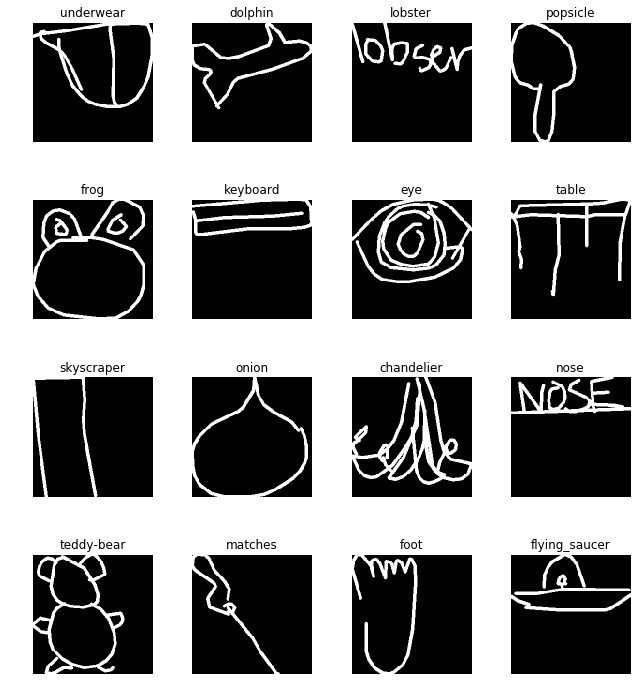

In [18]:
data_bunch.show_batch(rows=4)

In [19]:
# same argument as above - you might want to save this value for later use
batch_stats = data_bunch.batch_stats()
pd.to_pickle(batch_stats, 'data/batch_stats.pkl')
batch_stats = pd.read_pickle('data/batch_stats.pkl')

In [20]:
data_bunch.normalize(batch_stats);

## Train

In [21]:
name = f'res101-{sz}-three'

In [22]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [23]:
def map3(preds, targs):
    predicted_idxs = preds.sort(descending=True)[1]
    top_3 = predicted_idxs[:, :3]
    res = mapk([[t] for t in targs.cpu().numpy()], top_3.cpu().numpy(), 3)
    return torch.tensor(res)

In [24]:
learn = create_cnn(data_bunch, models.resnet101, metrics=[accuracy, map3])

In [25]:
learn.fit_one_cycle(2)

Total time: 51:39
epoch  train_loss  valid_loss  accuracy  map3    
1      1.580558    1.372836    0.657529  0.739637  (25:50)
2      1.265787    1.173210    0.705647  0.780245  (25:48)



In [25]:
learn.save(f'{name}-stage-1')

In [ ]:
learn.load(f'{name}-stage-1')

In [27]:
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [ ]:
fd = ImageDeleter(ds, idxs)

In [26]:
learn.unfreeze()

In [ ]:
learn.lr_find()
#learn.recorder.plot()

In [27]:
learn.fit_one_cycle(6, max_lr=6e-4)

epoch,train_loss,valid_loss,accuracy,map3
1,1.883975,1.577788,0.623353,0.706520
2,1.511579,1.308511,0.676294,0.754853
3,1.351835,1.192029,0.704765,0.778441


KeyboardInterrupt: 

In [ ]:
learn.save(f'{name}-stage-2')

In [ ]:
learn.load(f'{name}-stage-2');

In [ ]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
top_3 = np.argsort(preds.numpy())[:, ::-1][:, :3]

In [ ]:
labels = []
for i in range(top_3.shape[0]):
    labels.append(' '.join([learn.data.train_ds.classes[idx] for idx in top_3[i]]))

In [ ]:
labels[1]

In [ ]:
test_dl.dataset[1][0]

In [ ]:
key_ids = [path.stem.split('_')[1] for path in learn.data.test_dl.dl.dataset.x]

In [ ]:
os.makedirs(f'subs', exist_ok=True)
sub = pd.DataFrame({'key_id': key_ids, 'word': labels})
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [ ]:
pd.read_csv(f'subs/{name}.csv.gz').head()

In [ ]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"